## Analysis & Modelling

### Text Analysis on Restaurants Reviews posted on TripAdvisor

Continuing from the previous part, we will work on this NLP project for text analysis to predict sentiment. We will conduct topic analysis to associate topics with keywords from the Corpus. Then, we will classifier to predict the sentiment on from the modelled topics.

To work on topic modelling from the reviews on the restaurants, we will preprocess our tokens to use Genism and Spacy. These two has powerful features to model the data and infer the information for topic modelling, especially considering Lemmatization, Stopwords and POS tagging.

We will follow the LDA approach to model the possible topics.

Due to logistic constraints, we will free the occupied memory to run our analysis time by time. And also we will consider to take a representative sample from the large dataset.

### Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df = pd.read_csv('assets/barcelona.csv', index_col=False)
df.head()

,restaurant_name,rating_review,sample,review_full,text,tokenized,Word_Count
0,Chalito_Rambla,1,Negative,"Ok, this place is terrible! Came here bc we’ve...",ok place terrible come bc always walk around s...,"['ok', 'place', 'terrible', 'come', 'bc', 'alw...",163
1,Chalito_Rambla,5,Positive,This place was a great surprise. The food is d...,place great surprise food delicious dessert we...,"['place', 'great', 'surprise', 'food', 'delici...",44
2,Chalito_Rambla,5,Positive,The food is excellent.....the ambiance is very...,food excellent ambiance nice price affordable ...,"['food', 'excellent', 'ambiance', 'nice', 'pri...",25
3,Chalito_Rambla,5,Positive,"The food is execellent ,affortable price for p...",food execellent affortable price people friend...,"['food', 'execellent', 'affortable', 'price', ...",50
4,Chalito_Rambla,5,Positive,"Mr Suarez,The food at your restaurant was abso...",mr suarez food restaurant absolutely amazing h...,"['mr', 'suarez', 'food', 'restaurant', 'absolu...",35


In [3]:
import nltk
nltk.download('stopwords')

import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to C:\Users\Ali
[nltk_data]     Abdullah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will use NLTK stopwords corpus, modifying it to minimize the bias for further analysis.

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['food', 'place', 'restaurant', 'go', 'barcelona'])

In [5]:
df.head()

,restaurant_name,rating_review,sample,review_full,text,tokenized,Word_Count
0,Chalito_Rambla,1,Negative,"Ok, this place is terrible! Came here bc we’ve...",ok place terrible come bc always walk around s...,"['ok', 'place', 'terrible', 'come', 'bc', 'alw...",163
1,Chalito_Rambla,5,Positive,This place was a great surprise. The food is d...,place great surprise food delicious dessert we...,"['place', 'great', 'surprise', 'food', 'delici...",44
2,Chalito_Rambla,5,Positive,The food is excellent.....the ambiance is very...,food excellent ambiance nice price affordable ...,"['food', 'excellent', 'ambiance', 'nice', 'pri...",25
3,Chalito_Rambla,5,Positive,"The food is execellent ,affortable price for p...",food execellent affortable price people friend...,"['food', 'execellent', 'affortable', 'price', ...",50
4,Chalito_Rambla,5,Positive,"Mr Suarez,The food at your restaurant was abso...",mr suarez food restaurant absolutely amazing h...,"['mr', 'suarez', 'food', 'restaurant', 'absolu...",35


In [6]:
df['text'].head()

0    ok place terrible come bc always walk around s...
1    place great surprise food delicious dessert we...
2    food excellent ambiance nice price affordable ...
3    food execellent affortable price people friend...
4    mr suarez food restaurant absolutely amazing h...
Name: text, dtype: object

Due to logistic constraint, we will consider a sample of 20000 rows from the 'barcelona' dataframe to fit our model. We will take equal number of samples from both positive and negative reviews to keep control on bias/avoid overfitting of the model.

In [7]:
sample_df = df.groupby('sample').sample(n=10000, random_state=12)
df_1 = sample_df['text']
df_1.head()

396553    bit overrated place busy food good ate place well
94848     interesting place eat strange juxtaposition tr...
354828    second day barcelona sat friend late afternoon...
55258     found place tripadvisor surf great paella loca...
264608    look personalize service place felt owner wait...
Name: text, dtype: object

Let's start processing our text to get it ready to fit our model.

Tokenize words and Clean-Up Text

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(df_1))
print(data_words[:1])

[['bit', 'overrated', 'place', 'busy', 'food', 'good', 'ate', 'place', 'well']]


Creating Bigram and Trigram Models

In [9]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
print(bigram_mod[data_words[0]])

['bit', 'overrated', 'place', 'busy', 'food', 'good', 'ate', 'place', 'well']


Remove Stopwords, Make Bigrams and Lemmatize

In [10]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#   return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['bit', 'overrate', 'busy', 'good', 'eat', 'well']]


Create the Dictionary and Corpus needed for topic modelling

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out words that occur less than 10 by numbers in the documents, or more than 90% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [14]:
id2word[0]

'bit'

In [15]:
# human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bit', 1),
  ('busy', 1),
  ('eat', 1),
  ('good', 1),
  ('overrate', 1),
  ('well', 1)]]

### Building the Topic Model

We will considet LDA model for topic building

Optimal Number of Topics Based on Coherence Score: (Using UMass Measure)

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
start = 2
limit = 20
step = 2

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

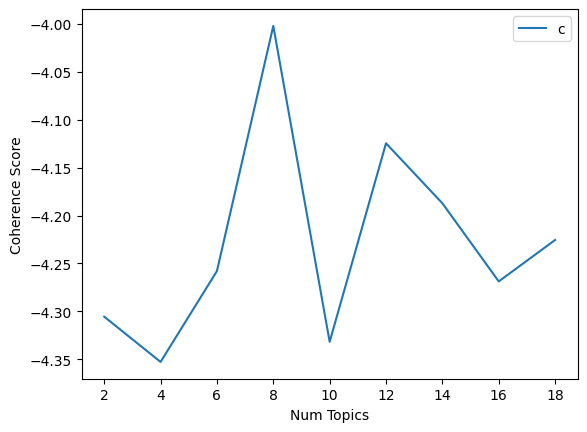

In [18]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [19]:
# print the coherence score
for m, cv in zip(x, coherence_values):
    print(f"Num Topics = {m} has Coherence Value of {round(cv, 4)}")

Num Topics = 2 has Coherence Value of -4.3056
Num Topics = 4 has Coherence Value of -4.3529
Num Topics = 6 has Coherence Value of -4.258
Num Topics = 8 has Coherence Value of -4.002
Num Topics = 10 has Coherence Value of -4.3319
Num Topics = 12 has Coherence Value of -4.1246
Num Topics = 14 has Coherence Value of -4.1872
Num Topics = 16 has Coherence Value of -4.2688
Num Topics = 18 has Coherence Value of -4.2256


We will consider 6 topics to build the topic model.

Building the LDA model

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=34,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

View the topics in LDA model

In [21]:
pprint(lda_model.print_topics())

[(0,
  '0.081*"paella" + 0.050*"seafood" + 0.040*"beautiful" + 0.026*"music" + '
  '0.025*"pleasant" + 0.023*"chef" + 0.023*"fast" + 0.022*"english" + '
  '0.022*"awesome" + 0.021*"beach"'),
 (1,
  '0.072*"service" + 0.057*"staff" + 0.043*"time" + 0.033*"visit" + '
  '0.032*"meal" + 0.025*"experience" + 0.023*"night" + 0.021*"lunch" + '
  '0.020*"day" + 0.019*"serve"'),
 (2,
  '0.055*"price" + 0.039*"find" + 0.034*"bar" + 0.030*"dinner" + 0.029*"amaze" '
  '+ 0.027*"worth" + 0.024*"local" + 0.023*"look" + 0.017*"stay" + '
  '0.016*"beer"'),
 (3,
  '0.038*"get" + 0.037*"make" + 0.035*"come" + 0.034*"order" + 0.028*"back" + '
  '0.024*"even" + 0.024*"eat" + 0.019*"waiter" + 0.018*"drink" + 0.018*"take"'),
 (4,
  '0.086*"table" + 0.060*"wait" + 0.037*"walk" + 0.036*"busy" + 0.035*"sit" + '
  '0.034*"seat" + 0.032*"book" + 0.029*"reservation" + 0.027*"open" + '
  '0.026*"arrive"'),
 (5,
  '0.074*"good" + 0.040*"great" + 0.028*"recommend" + 0.026*"friendly" + '
  '0.024*"nice" + 0.021*"real

Compute Model Perplexity and Coherence Score

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score considering U_Mass: ', coherence_lda)


Perplexity:  -6.856949455259501

Coherence Score considering U_Mass:  -2.7269316842827074


##### Topic Analysis for the Model with Optimal Number of Topics

In [23]:
optimal_num_topics = 6

optimal_keywords = 40

optimal_lda_model = lda_model

In [24]:
optimal_lda_topics = optimal_lda_model.show_topics(
    num_topics=optimal_num_topics,
    num_words=optimal_keywords,
    formatted=False
)

In [25]:
for topic_id, topic in optimal_lda_topics:
    words = ', '.join([word[0] for word in topic])
    print(f'Topic {topic_id}: {words}\n')

Topic 0: paella, seafood, beautiful, music, pleasant, chef, fast, english, awesome, beach, light, rice, lucky, pack, cozy, travel, flavor, world, vegetarian, comfortable, rush, vibe, environment, knowledgeable, gothic_quarter, slightly, occasion, relaxed, mussel, fairly, sea, create, guide, prompt, freshly, beautifully, lobster, match, rib, strongly

Topic 1: service, staff, time, visit, meal, experience, night, lunch, day, serve, great, first, wonderful, course, fantastic, helpful, enjoy, main, return, amazing, couple, cocktail, trip, thank, glass, din, set, prepare, next, work, group, need, starter, kitchen, watch, second, help, lovely, however, seem

Topic 2: price, find, bar, dinner, amaze, worth, local, look, stay, beer, spanish, reasonable, area, hotel, attentive, location, much, perfect, stop, close, drink, visit, fun, tourist, many, home, city, view, expensive, include, list, relax, street, twice, high, pretty, sure, especially, sangria, reasonably

Topic 3: get, make, come, or

#### EDA on the Topics from the Model

We will try to dig down deep to get an idea on the relevancy of the topics. For that, we will implement some visualization and try to analyze the keywords for each topics.

What is the dominant topic and its percentage contribution in each document/row:

In [26]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # init output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                new_topic_df = pd.DataFrame({'Dominant_Topic': [int(topic_num)],
                                            'Perc_Contribution': [round(prop_topic, 4)],
                                            'Topic_Keywords': [topic_keywords]})
                new_topic_df = new_topic_df.reset_index(drop=True)
                sent_topics_df = pd.concat([sent_topics_df, new_topic_df], ignore_index=True)
            else:
                break
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5,0.4052,"good, great, recommend, friendly, nice, really...","[bit, overrate, busy, good, eat, well]"
1,1,5,0.6576,"good, great, recommend, friendly, nice, really...","[interesting, eat, strange, juxtaposition, tri..."
2,2,3,0.3555,"get, make, come, order, back, even, eat, waite...","[second, day, sit, friend, late, afternoon, hu..."
3,3,5,0.3438,"good, great, recommend, friendly, nice, really...","[find, tripadvisor, surf, great, location, nic..."
4,4,3,0.3363,"get, make, come, order, back, even, eat, waite...","[look, personalize, service, feel, owner, wait..."
5,5,5,0.3647,"good, great, recommend, friendly, nice, really...","[find, walk, full, local, try, disapoitment, g..."
6,6,5,0.3644,"good, great, recommend, friendly, nice, really...","[terrible, definitely, avoid, order, paella, s..."
7,7,3,0.3040,"get, make, come, order, back, even, eat, waite...","[wait, seat, minute, drink, order, take, order..."
8,8,5,0.3320,"good, great, recommend, friendly, nice, really...","[take, forever, get, tapa, bring, separately, ..."
9,9,3,0.3063,"get, make, come, order, back, even, eat, waite...","[recommend, guy, visit, sit, average, way, exp..."


In [27]:
df_dominant_topic['Keywords'].unique()

array(['good, great, recommend, friendly, nice, really, well, tapa, wine, menu',
       'get, make, come, order, back, even, eat, waiter, drink, take',
       'service, staff, time, visit, meal, experience, night, lunch, day, serve',
       'price, find, bar, dinner, amaze, worth, local, look, stay, beer',
       'table, wait, walk, busy, sit, seat, book, reservation, open, arrive'],
      dtype=object)

#### The most representative sentence for each topic

In [28]:
# display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                            grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# reset index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# format 
sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Representative Text']

# show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1,0.3742,"service, staff, time, visit, meal, experience, night, lunch, day, serve","[night, dinner, first, try, typical, tapa, tomate, croqueta, fine, main, course, great, average,..."
1,2,0.3302,"price, find, bar, dinner, amaze, worth, local, look, stay, beer","[consider, misuse, review, system, street, list, find, street, number, apartment, building, look..."
2,3,0.5652,"get, make, come, order, back, even, eat, waiter, drink, take","[come, lunch, waitress, confirm, order, however, come, bacon, mixed, spinach, apologise, take, p..."
3,4,0.2724,"table, wait, walk, busy, sit, seat, book, reservation, open, arrive","[book, table, arrive, wait, door, serve, couple, also, wait, number, staff, walk, pass, acknowle..."
4,5,0.6576,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu","[interesting, eat, strange, juxtaposition, trip_advisor, give, super, high, rating, agree, small..."


#### Word Cloud of Top N Keywords for Each Topic

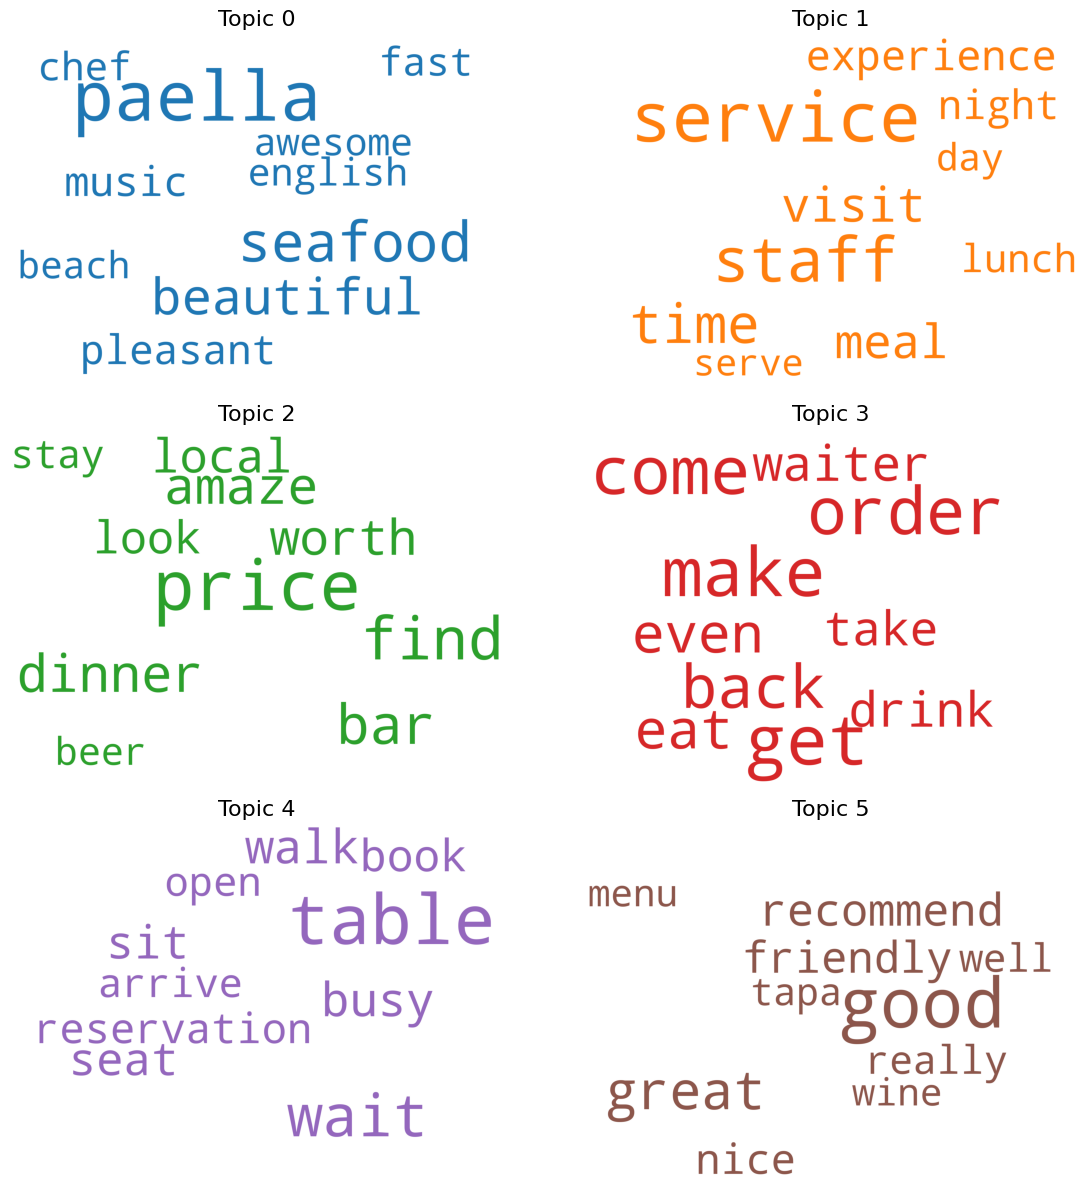

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                background_color='white',
                width=2500,
                height=1800,
                max_words=10,
                colormap='tab10',
                color_func=lambda *args, **kwargs: cols[i],
                prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3,2, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Count of Topic Keywords

C:\Users\Ali Abdullah\AppData\Local\Temp\ipykernel_4336\4047920375.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


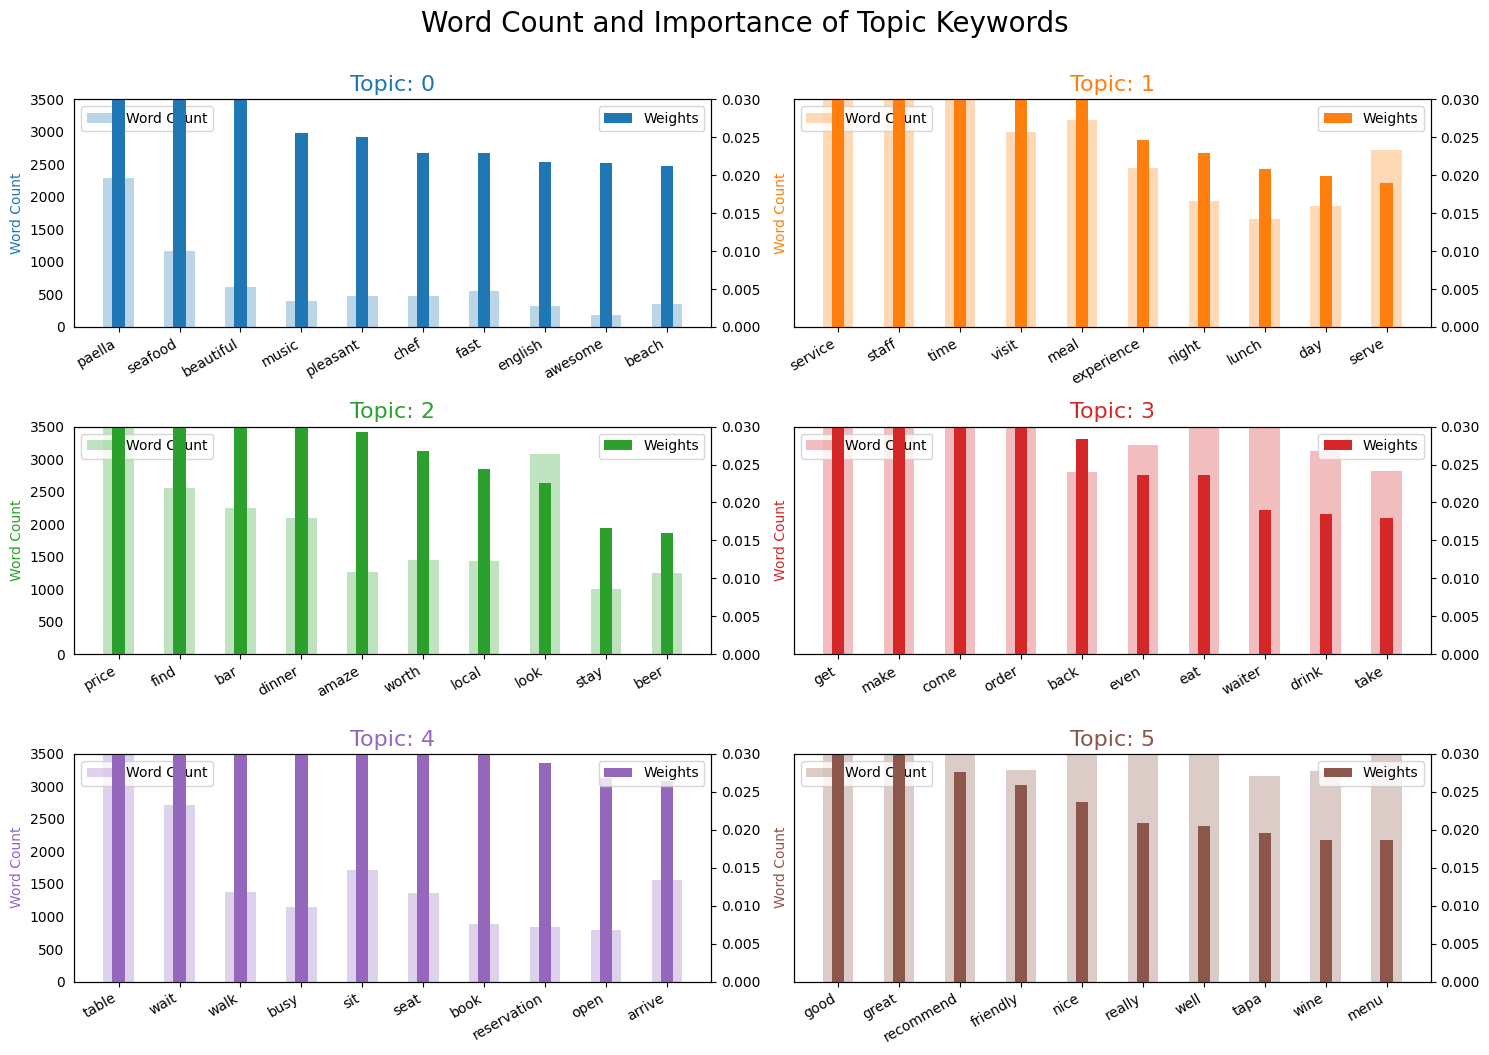

In [30]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(15,10), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=1)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.05)
plt.show()

#### Sparsness of Topic keywords in sentences

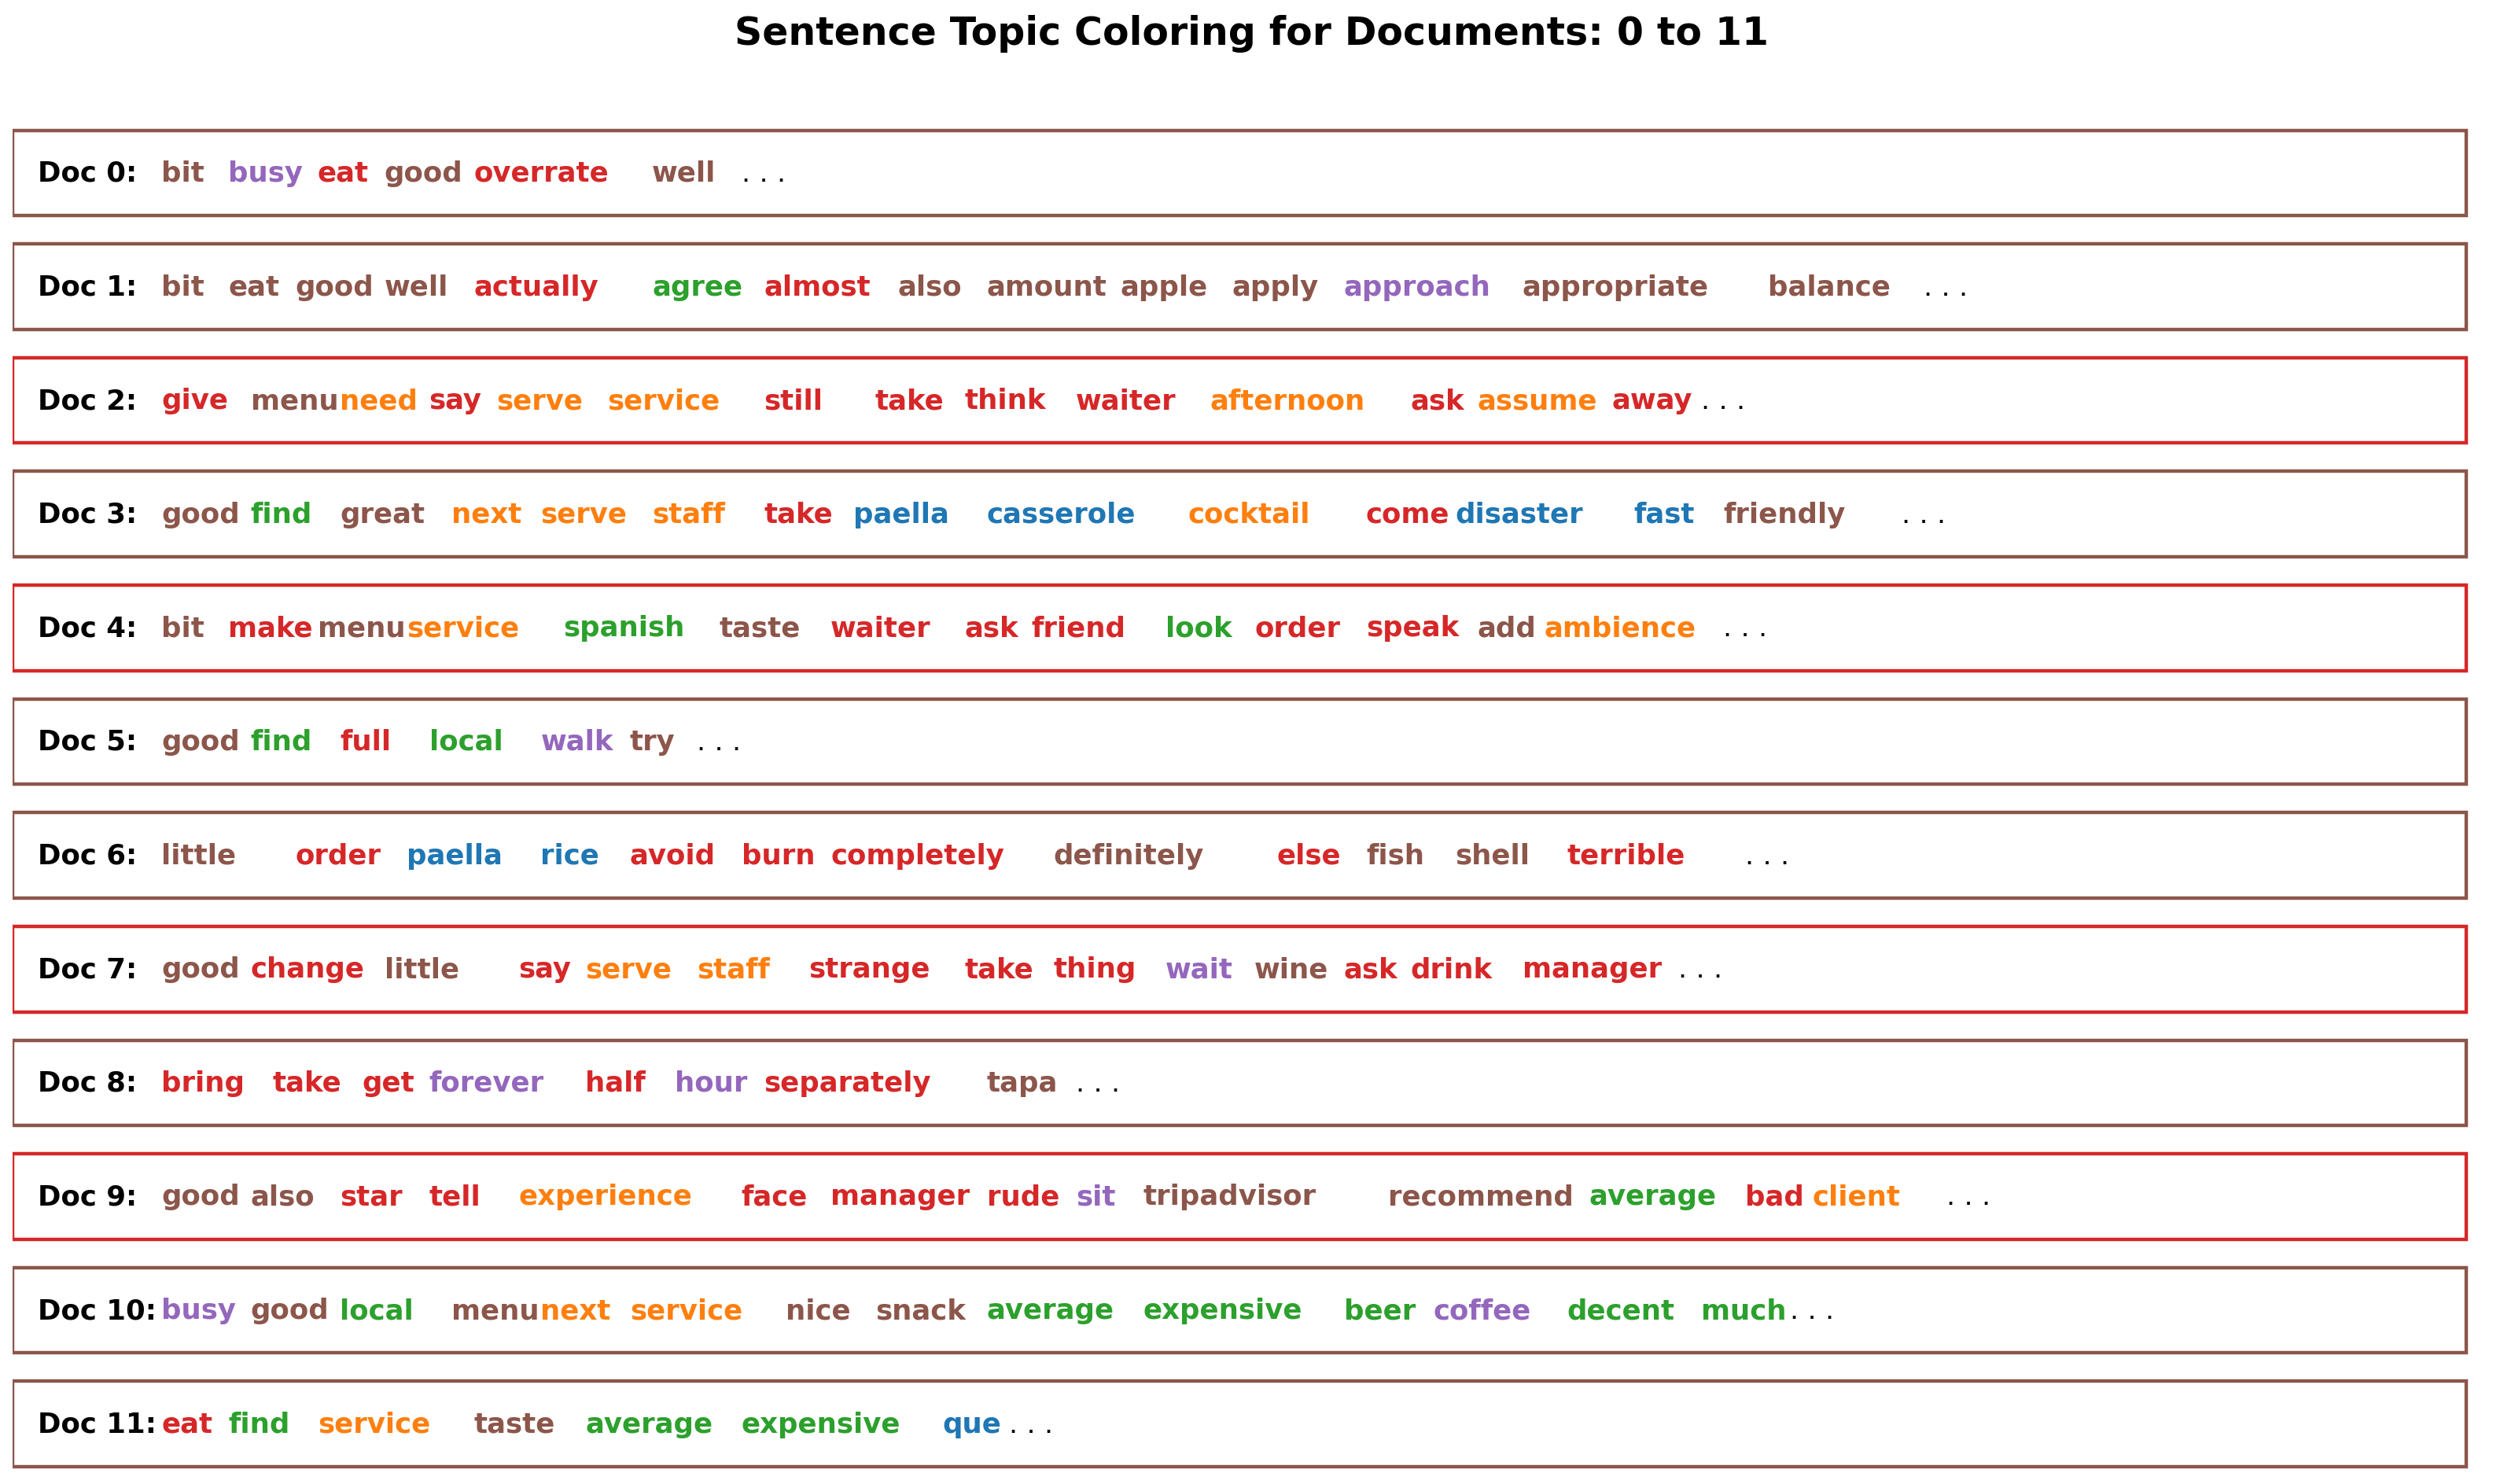

In [31]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [32]:
import gc
gc.collect()

30146

#### What are the most discussed topics in the documents?

In [33]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

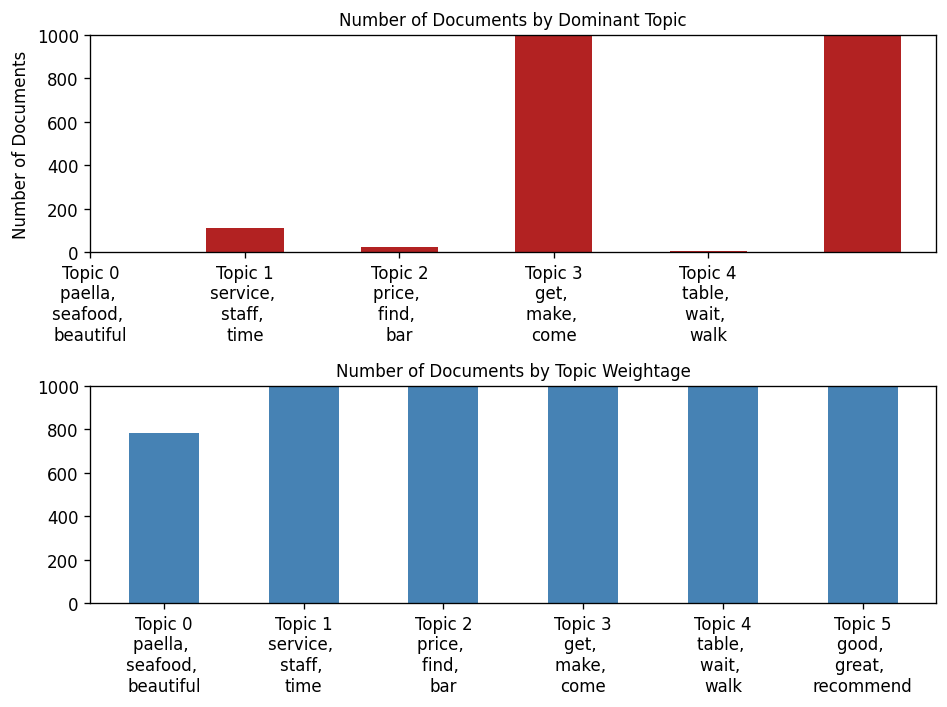

In [34]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.tight_layout()
plt.show()

Observation:

From the graphs and the analysis above, we see that the **'Topic 5'** is the most discussed Dominant Topic in the whole document which is related to **'Quality of Service'**.

The 2nd place for dominant Topic is the '**Topic 3**' which is related to **'Waiting Service'**.

In [35]:
# Save the Model for Future use

lda_model.save('lda_model.model')

#### Topic Distribution across documents

In [36]:
# number of documents for each topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# percentage of documents for each topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# concatenate column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# change column names 
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,5,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu",NaN,NaN
1,5,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu",111.0,0.0056
2,3,"get, make, come, order, back, even, eat, waiter, drink, take",21.0,0.0010
3,5,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu",1742.0,0.0871
4,3,"get, make, come, order, back, even, eat, waiter, drink, take",4.0,0.0002
...,...,...,...,...
19995,5,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu",NaN,NaN
19996,5,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu",NaN,NaN
19997,5,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu",NaN,NaN
19998,5,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu",NaN,NaN


In [37]:
list(df_dominant_topics['Topic_Keywords'].unique())

['good, great, recommend, friendly, nice, really, well, tapa, wine, menu',
 'get, make, come, order, back, even, eat, waiter, drink, take',
 'service, staff, time, visit, meal, experience, night, lunch, day, serve',
 'price, find, bar, dinner, amaze, worth, local, look, stay, beer',
 'table, wait, walk, busy, sit, seat, book, reservation, open, arrive']

### Topic for Predicting Sentiment:

Now, we will try different classifiers to classify the sentiment (Positive or Negative Review) using the Dominant Topic as Regressors.

In [38]:
df_dominant_topic.reset_index(drop=True, inplace=True)
sample_df.reset_index(drop=True, inplace=True)
finaldf = pd.concat([df_dominant_topic, sample_df], axis=1)

In [39]:
finaldf.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,restaurant_name,rating_review,sample,review_full,text,tokenized,Word_Count
0,0,5,0.4052,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu","[bit, overrate, busy, good, eat, well]",Ciudad_Condal,3,Negative,"A bit of a overrated place, very busy. The food is good, but we ate at some other places where i...",bit overrated place busy food good ate place well,"['bit', 'overrated', 'place', 'busy', 'food', 'good', 'ate', 'place', 'well']",23
1,1,5,0.6576,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu","[interesting, eat, strange, juxtaposition, trip_advisor, give, super, high, rating, agree, small...",Osmosis,3,Negative,An interesting place to eat - but some strange juxtapositions. Trip Advisor gives it a super hig...,interesting place eat strange juxtaposition trip advisor give super high rating agree small rest...,"['interesting', 'place', 'eat', 'strange', 'juxtaposition', 'trip', 'advisor', 'give', 'super', ...",553
2,2,3,0.3555,"get, make, come, order, back, even, eat, waiter, drink, take","[second, day, sit, friend, late, afternoon, hungry, think, take, opportunity, drink, doorman, fo...",Restaurant_Amaya,1,Negative,Our second day in Barcelona I sat down with a friend late afternoon as she was hungry and I thou...,second day barcelona sat friend late afternoon hungry think take opportunity drink doorman force...,"['second', 'day', 'barcelona', 'sat', 'friend', 'late', 'afternoon', 'hungry', 'think', 'take', ...",210
3,3,5,0.3438,"good, great, recommend, friendly, nice, really, well, tapa, wine, menu","[find, tripadvisor, surf, great, location, nice, staff, friendly, serve, fast, casserole, mussel...",My_Way,3,Negative,We’ve found this place on TripAdvisor while surfing for a great paella location. The restaurant ...,found place tripadvisor surf great paella location restaurant nice staff friendly food serve fas...,"['found', 'place', 'tripadvisor', 'surf', 'great', 'paella', 'location', 'restaurant', 'nice', '...",87
4,4,3,0.3363,"get, make, come, order, back, even, eat, waiter, drink, take","[look, personalize, service, feel, owner, waiter, become, unfriendly, ask, menu, spanish, speak,...",Marisqueria_Funicular,2,Negative,If you are looking for personalized service this is not the place. It felt that the owner/waiter...,look personalize service place felt owner waiter become unfriendly ask menu spanish menu awailab...,"['look', 'personalize', 'service', 'place', 'felt', 'owner', 'waiter', 'become', 'unfriendly', '...",101


In [40]:
finaldf.columns

Index(['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text', 'restaurant_name', 'rating_review', 'sample', 'review_full',
       'text', 'tokenized', 'Word_Count'],
      dtype='object')

We will define our classification model such as:

Our Response variable: 'sample' (i.e. positive or negative review). Our Independent variables: 'Dominant_Topic' and 'Word_count'.

At this point, we can interprete that our topic modelling implementation has driven our Unsupervised Modelling to a supervised one.

In [41]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [42]:
finaldf = pd.get_dummies(finaldf, columns=['sample', 'Dominant_Topic'])

In [43]:
list(finaldf.columns)

['Document_No',
 'Topic_Perc_Contrib',
 'Keywords',
 'Text',
 'restaurant_name',
 'rating_review',
 'review_full',
 'text',
 'tokenized',
 'Word_Count',
 'sample_Negative',
 'sample_Positive',
 'Dominant_Topic_1',
 'Dominant_Topic_2',
 'Dominant_Topic_3',
 'Dominant_Topic_4',
 'Dominant_Topic_5']

#### Classification of Sentiment for Different Classifier using **Topics as Regressor**

In [44]:
X= finaldf[['Dominant_Topic_1','Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5','Word_Count']]

In [45]:
y = finaldf['sample_Positive']

In [46]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.80,random_state = 42)

c:\Users\Ali Abdullah\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\Users\Ali Abdullah\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\Ali Abdullah\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


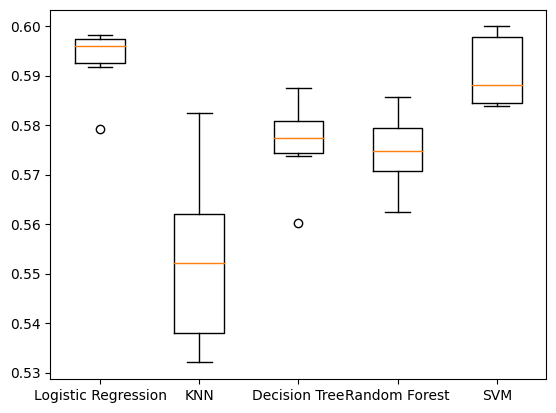

In [47]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {"Logistic Regression": LogisticRegression(solver = 'newton-cg', max_iter = 500, C = 1000),
          "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "SVM": SVC(gamma='auto')
          }

results = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, Xtrain, ytrain, cv=kf)
    results.append(cv_results)


plt.boxplot(results, labels= models.keys())
plt.show()

In [59]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

score = []
m_name = []
for name, model in models.items():
    model.fit(Xtrain, ytrain)
    test_score = model.score(Xtest, ytest)
    score.append(test_score)
    m_name.append(name)
    prediction = model.predict(Xtest)
    report = classification_report(prediction, ytest)
    mat = confusion_matrix(prediction, ytest)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} Confusion Matrix:\n{}".format(name, mat))
    print("{} Classification Report:\n{}".format(name, report))

Logistic Regression Test Set Accuracy: 0.5905
Logistic Regression Confusion Matrix:
[[ 654  273]
 [1365 1708]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.71      0.44       927
           1       0.86      0.56      0.68      3073

    accuracy                           0.59      4000
   macro avg       0.59      0.63      0.56      4000
weighted avg       0.74      0.59      0.62      4000



KNN Test Set Accuracy: 0.56375
KNN Confusion Matrix:
[[1022  748]
 [ 997 1233]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.54      1770
           1       0.62      0.55      0.59      2230

    accuracy                           0.56      4000
   macro avg       0.56      0.57      0.56      4000
weighted avg       0.57      0.56      0.57      4000

Decision Tree Test Set Accuracy: 0.5865
Decision Tree Confusion Matrix:
[[ 855  490]
 [1164 1491]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.64      0.51      1345
           1       0.75      0.56      0.64      2655

    accuracy                           0.59      4000
   macro avg       0.59      0.60      0.58      4000
weighted avg       0.64      0.59      0.60      4000

Random Forest Test Set Accuracy: 0.58375
Random Forest Confusion Matrix:
[[ 775  421]
 [1244 1560]]
Ran

In [64]:
result = pd.DataFrame({'Name': m_name, 'Score': score})

result.head()

,Name,Score
0,Logistic Regression,0.59050
1,KNN,0.56375
2,Decision Tree,0.58650
3,Random Forest,0.58375
4,SVM,0.58500


In [66]:
result.sort_values(by='Score', ascending=False)

,Name,Score
0,Logistic Regression,0.59050
2,Decision Tree,0.58650
4,SVM,0.58500
3,Random Forest,0.58375
1,KNN,0.56375


Obeservation:

From the Box plot above, we notice that the Logistic Regression classifier performs well in terms of accuracy and sparsness.

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

rf = RandomForestRegressor(n_estimators=150)
rf.fit(Xtrain, ytrain)

RandomForestRegressor(n_estimators=150)

<Axes: >

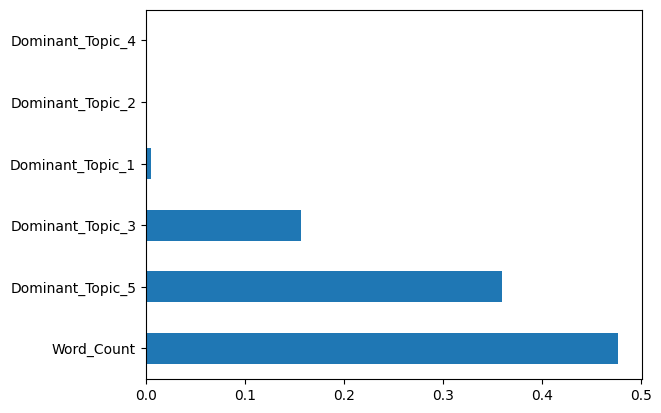

In [50]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=Xtrain.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot(kind='barh')
# feature_importances.plot.bar();

Observation:

We see that, wordcount contributes most for classifying reviews. Also, from this analysis, we find that Dominant topic 5 and Dominant topic 3 are the significant contributors for Positive Reviews.